In [1]:
from __future__ import division, print_function
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import files
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

In [ ]:
uploaded = files.upload()

Saving ICT_Subdimension_Dataset.csv to ICT_Subdimension_Dataset.csv


In [ ]:
# 1. Загрузка данных
data_path = 'ICT_Subdimension_Dataset.csv'
df = pd.read_csv(data_path)

# Вывод информации о данных
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 20 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   City                                              180 non-null    object 
 1   Year                                              180 non-null    int64  
 2   Household Internet Access (%)                     180 non-null    float64
 3   Fixed Broadband Subscriptions (%)                 180 non-null    float64
 4   Wireless Broadband Subscriptions (%)              180 non-null    float64
 5   Wireless Broadband Coverage 3G (%)                180 non-null    float64
 6   Wireless Broadband Coverage 4G (%)                180 non-null    float64
 7   Smart Water Meters (%)                            180 non-null    float64
 8   Smart Electricity Meters (%)                      180 non-null    float64
 9   Dynamic Public Transp

In [ ]:
# Пример задачи бинарной классификации: создадим целевой столбец `target`
# Например: наличие Wi-Fi в публичных местах больше медианы — класс 1, иначе — класс 0
df['target'] = (df['Availability of WIFI in Public Areas (count)'] >
                df['Availability of WIFI in Public Areas (count)'].median()).astype(int)

# Создание синтезированных признаков
df['internet_growth'] = (df['Household Internet Access (%)'] -
                         df['Fixed Broadband Subscriptions (%)']) / df['Fixed Broadband Subscriptions (%)']
df['smart_meter_penetration'] = (df['Smart Water Meters (%)'] +
                                 df['Smart Electricity Meters (%)']) / 2

# Выбор признаков
X = df[['internet_growth', 'smart_meter_penetration',
        'Household Internet Access (%)', 'Fixed Broadband Subscriptions (%)']]
y = df['target']  # целевая переменная

# Вывод выбранных признаков
print("\nПризнаки для обучения:")
print(X.head())

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Замена NaN значений на медиану
X_train = X_train.apply(lambda x: x.fillna(x.median()), axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.median()), axis=0)
y_train = y_train.fillna(y_train.median())
y_test = y_test.fillna(y_test.median())

# Просмотр размеров тренировочного и тестового наборов
print("\nРазмеры наборов данных:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

# Обучение модели без масштабирования
model_no_scaling = LogisticRegression(random_state=42)
model_no_scaling.fit(X_train, y_train)

# Предсказания на тестовых данных
y_pred_no_scaling = model_no_scaling.predict(X_test)

# Оценка точности
accuracy_no_scaling = accuracy_score(y_test, y_pred_no_scaling)
print(f"Точность модели без масштабирования: {accuracy_no_scaling:.4f}")

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели с масштабированием
model_with_scaling = LogisticRegression(random_state=42)
model_with_scaling.fit(X_train_scaled, y_train)

# Предсказания на тестовых данных
y_pred_with_scaling = model_with_scaling.predict(X_test_scaled)

# Оценка точности модели с масштабированием
accuracy_with_scaling = accuracy_score(y_test, y_pred_with_scaling)
print(f"Точность модели с масштабированием: {accuracy_with_scaling:.4f}")




Признаки для обучения:
   internet_growth  smart_meter_penetration  Household Internet Access (%)  \
0         0.655208                   38.350                          79.45   
1         0.620110                   34.680                          88.62   
2         0.664212                   29.705                          79.10   
3         0.447000                   33.125                          86.82   
4         0.683115                   29.760                          80.84   

   Fixed Broadband Subscriptions (%)  
0                              48.00  
1                              54.70  
2                              47.53  
3                              60.00  
4                              48.03  

Размеры наборов данных:
X_train: (144, 4), X_test: (36, 4)
y_train: (144,), y_test: (36,)
Точность модели без масштабирования: 0.7500
Точность модели с масштабированием: 0.7222


In [ ]:
# Список значений гиперпараметра C
Cs = np.logspace(-3, 1, 10)  # Значения C от 0.001 до 10

# Список для хранения значений AUC-ROC для каждого C
scores = []

# Обучение модели и расчет AUC-ROC для каждого C
for C_val in Cs:
    lr = LogisticRegression(C=C_val, random_state=42)
    # Обучение модели на тренировочных данных
    lr.fit(X_train_scaled, y_train)

    # Получение вероятностей для расчета AUC-ROC
    y_pred_prob = lr.predict_proba(X_test_scaled)[:, 1]

    # Расчет AUC-ROC на основе меток класса в тестовой выборке y_test и предсказанных вероятностей y_pred_prob
    auc_score = roc_auc_score(y_test, y_pred_prob)
    scores.append(auc_score)

    # Вывод значения C и соответствующего AUC-ROC
    print(f"Значение C: {C_val:.4f}, AUC-ROC: {auc_score:.9f}")

Значение C: 0.0010, AUC-ROC: 0.771103896
Значение C: 0.0028, AUC-ROC: 0.774350649
Значение C: 0.0077, AUC-ROC: 0.787337662
Значение C: 0.0215, AUC-ROC: 0.800324675
Значение C: 0.0599, AUC-ROC: 0.810064935
Значение C: 0.1668, AUC-ROC: 0.803571429
Значение C: 0.4642, AUC-ROC: 0.816558442
Значение C: 1.2915, AUC-ROC: 0.832792208
Значение C: 3.5938, AUC-ROC: 0.855519481
Значение C: 10.0000, AUC-ROC: 0.845779221


In [ ]:
# Получение AUC-ROC для дефолтного значения C (C=1)
lr_default = LogisticRegression(C=1, max_iter=1000, random_state=42)
lr_default.fit(X_train_scaled, y_train)
y_pred_prob_default = lr_default.predict_proba(X_test_scaled)[:, 1]
score_C_1 = roc_auc_score(y_test, y_pred_prob_default)


**Построение графика AUC-ROC от значения C**

Этот фрагмент строит график зависимости AUC-ROC от значения гиперпараметра C. Мы также добавляем горизонтальную линию для дефолтного значения C=1.

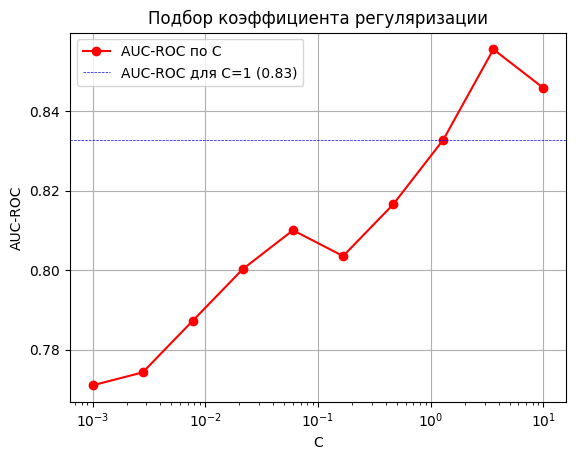

In [ ]:
# Построение графика AUC-ROC от C
plt.plot(Cs, scores, 'ro-', label='AUC-ROC по C')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Подбор коэффициента регуляризации')

# Горизонтальная линия для дефолтного C
plt.axhline(y=score_C_1, linewidth=.5, color='b', linestyle='dashed', label=f'AUC-ROC для C=1 ({score_C_1:.2f})')

plt.legend()
plt.grid()
plt.show()


In [ ]:
# Обучение модели на всей тренировочной выборке с оптимальным C
lr = LogisticRegression(C=3.5938, random_state=17, solver='liblinear')
lr.fit(X_train_scaled, y_train)

# Прогноз вероятностей для тестовой выборки
y_test_prob = lr.predict_proba(X_test_scaled)[:, 1]

# Создаем DataFrame с метриками для записи
baseline_metrics = []

# Генерация метрик для каждой строки тестовой выборки
for i in range(len(y_test_prob)):
    row_metrics = {
        'Test_Index': i + 1,  # Индекс строки в тестовом наборе
        'Predicted_Probability': y_test_prob[i]
    }
    baseline_metrics.append(row_metrics)

# Создание DataFrame из списка метрик
baseline_df = pd.DataFrame(baseline_metrics)

# Сохранение в CSV файл
baseline_path = 'baseline_metrics.csv'
baseline_df.to_csv(baseline_path, index=False)

print(baseline_df.head())


   Test_Index  Predicted_Probability
0           1               0.484124
1           2               0.379251
2           3               0.823506
3           4               0.549151
4           5               0.316067
